## Модель оттока клиентов

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1 Подготовка данных

In [19]:
data = pd.read_csv('churn_train.txt', header=0, sep='\t')

In [20]:
data.head()

,client_id,month_number,age,lifetime,beh_score,region,channel,avg_transaction_sum,total_products,deposit,is_package,salary_bucket,churn
0,20201,2,38,21,"2,73",Moscow,Online,345,1,1,1,70000.0,0
1,42943,2,30,21,"2,80",Moscow,Branch,269,1,1,1,30000.0,0
2,27570,1,48,13,"2,80",Regions,Online,327,1,1,1,150000.0,1
3,25037,3,40,15,"2,68",Moscow,Online,0,1,1,1,30000.0,0
4,47546,2,20,21,"2,88",Saint-Petersbourgh,Branch,0,1,1,0,190000.0,0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8305 entries, 0 to 8304
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            8305 non-null   int64  
 1   month_number         8305 non-null   int64  
 2   age                  8305 non-null   int64  
 3   lifetime             8305 non-null   int64  
 4   beh_score            8305 non-null   object 
 5   region               8305 non-null   object 
 6   channel              8305 non-null   object 
 7   avg_transaction_sum  8305 non-null   int64  
 8   total_products       8305 non-null   int64  
 9   deposit              8305 non-null   int64  
 10  is_package           8305 non-null   int64  
 11  salary_bucket        8304 non-null   float64
 12  churn                8305 non-null   int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 843.6+ KB


Один пропуск данных имеются в одном столбце salary_bucket, удалим объект с недостающими данными

In [25]:
data_dropna = data.dropna()
data_dropna.shape

(8304, 13)

In [26]:
data_dropna.describe()

,client_id,month_number,age,lifetime,avg_transaction_sum,total_products,deposit,is_package,salary_bucket,churn
count,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000
mean,30028.858382,2.001566,39.410886,17.026132,218.323699,1.534441,0.703998,0.517702,99926.541426,0.266739
std,11554.946075,0.810697,10.519758,2.897987,169.285964,0.579067,0.456519,0.499717,57532.939829,0.442281
min,10005.000000,1.000000,18.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,20063.000000,1.000000,32.000000,15.000000,0.000000,1.000000,0.000000,0.000000,50000.000000,0.000000
50%,30066.500000,2.000000,38.000000,17.000000,311.000000,1.000000,1.000000,1.000000,100000.000000,0.000000
75%,39735.750000,3.000000,44.000000,20.000000,358.000000,2.000000,1.000000,1.000000,150000.000000,1.000000
max,49997.000000,3.000000,92.000000,22.000000,501.000000,4.000000,1.000000,1.000000,200000.000000,1.000000


In [29]:
data_dropna.region.unique()

array(['Moscow', 'Regions', 'Saint-Petersbourgh'], dtype=object)

In [30]:
data_dropna.nunique()

client_id              7496
month_number              3
age                      36
lifetime                 11
beh_score                39
region                    3
channel                   2
avg_transaction_sum     282
total_products            4
deposit                   2
is_package                2
salary_bucket            21
churn                     2
dtype: int64

In [33]:
data_dropna['region'].value_counts()

Moscow                4163
Regions               2075
Saint-Petersbourgh    2066
Name: region, dtype: int64

In [35]:
data_dropna['churn'].value_counts()

0    6089
1    2215
Name: churn, dtype: int64

Средний возраст клиентов составляет около 39.5 лет. Процент оттока клиентов составил 36%

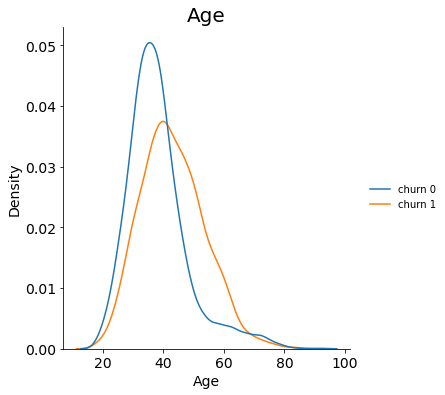

In [43]:
sns.displot(
    {
        "churn 0": data_dropna[data_dropna.churn == 0].age,
        "churn 1": data_dropna[data_dropna.churn == 1].age
    },
    kind="kde",
    common_norm=False
)

plt.title('Age', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Возрасть ушедших клиентов смещен в большую сторону относительно возраста лояльных клиентов 

Отбросим несущественные (на первый взгляд) признаки и воспользуемся minmaxscaler'ом для числовых признаков и OneHotEncoder для категориальных

In [69]:
data2 = data_dropna.drop(columns = ['client_id'])
data3 = data2.drop(columns = ['month_number'])

In [71]:
data3['beh_score'] = [x.replace(',', '.') for x in data3['beh_score']]
data3['beh_score'] = data3['beh_score'].astype(float)

In [74]:
data3.head()

,age,lifetime,beh_score,region,channel,avg_transaction_sum,total_products,deposit,is_package,salary_bucket,churn
0,38,21,2.73,Moscow,Online,345,1,1,1,70000.0,0
1,30,21,2.80,Moscow,Branch,269,1,1,1,30000.0,0
2,48,13,2.80,Regions,Online,327,1,1,1,150000.0,1
3,40,15,2.68,Moscow,Online,0,1,1,1,30000.0,0
4,20,21,2.88,Saint-Petersbourgh,Branch,0,1,1,0,190000.0,0


In [75]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [76]:
y = data3['churn']
X = data3.drop(columns = ['churn'])
y.shape, X.shape

((8304,), (8304, 10))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13, 
                                                    shuffle = True, stratify = y)

In [86]:
X_train_num = X_train.select_dtypes(exclude = 'object')
X_train_cat = X_train.select_dtypes(include = 'object')

In [94]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train_num)
X_train_scal = pd.DataFrame(X_train_sc, columns=list(X_train_num.columns.values), index=list(X_train_num.index))
X_train_scal['ind'] = X_train_scal.index

In [98]:
dummies = OneHotEncoder(sparse=False)
data_dummies_train = dummies.fit_transform(X_train_cat)
X_train_dum = pd.DataFrame(data_dummies_train, index=list(X_train_cat.index))
X_train_dum['ind'] = X_train_dum.index

In [106]:
X_train_merge = pd.merge(X_train_scal, X_train_dum, how = 'inner', on ='ind')
X_train_fin = X_train_merge.drop(columns=['ind'])

In [108]:
X_test_num = X_test.select_dtypes(exclude = 'object')
X_test_cat = X_test.select_dtypes(include = 'object')

In [109]:
X_test_sc = scaler.transform(X_test_num)
X_test_scal = pd.DataFrame(X_test_sc, columns=list(X_test_num.columns.values), index=list(X_test_num.index))
X_test_scal['ind'] = X_test_scal.index

In [110]:
data_dummies_test = dummies.transform(X_test_cat)
X_test_dum = pd.DataFrame(data_dummies_test, index=list(X_test_cat.index))
X_test_dum['ind'] = X_test_dum.index

In [111]:
X_test_merge = pd.merge(X_test_scal, X_test_dum, how = 'inner', on ='ind')
X_test_fin = X_test_merge.drop(columns=['ind'])

### Моделирование

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve

Если банку нужно предсказать больше уходящих клиентов, то лучше ориентироваться на  recall, если нужно более точно определить нелояльного клиента, то precision.

In [116]:
logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train_fin, y_train)

y_pred = logreg.predict(X_test_fin)
y_score = logreg.predict_proba(X_test_fin)[:,1]

In [118]:
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

precision: 0.37857142857142856
recall: 0.5740072202166066


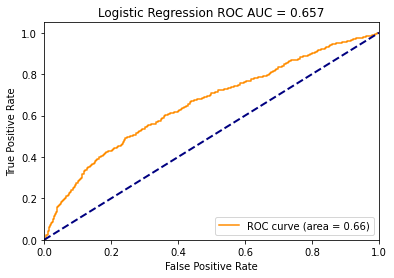

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [120]:
gradboo = GradientBoostingClassifier(n_estimators=200,max_depth=1)
gradboo.fit(X_train_fin, y_train)
y_pred = gradboo.predict(X_test_fin)
print('Precision на тесте:', precision_score(y_test, y_pred))
print('Recall на тесте:', recall_score(y_test, y_pred))

Precision на тесте: 0.7604166666666666
Recall на тесте: 0.26353790613718414


In [122]:
y_score = gradboo.predict_proba(X_test_fin)[:,1]

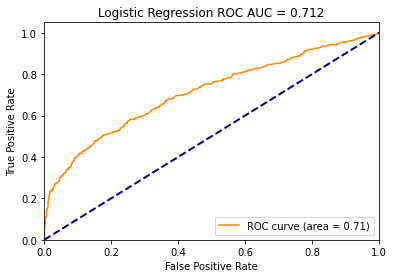

In [123]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

Модель на основе лог. регрессии показала более высокий recall, градиентный бустинг имеет более высокий precision.
Для бустинга scaler использовать было не обязательно, а в случае применения, например catboost, можно было не кодировать и категориальные признаки.

### Профиль склонного к оттоку клиента

Клиент, склонный к оттоку, имеет средний возраст около 43 лет(выше возраста всех клиентов), среднюю сумму транзакции больше, чем у среднего клиента, и, если я правильно интерпретировал значение признака 'is_package', меньшую вероятность того, что у него подключен пакет услуг банка.